# Mini Hydrogen Case Study

In [1]:
import bw2data as bd
from datetime import datetime

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
bd.projects.set_current("optimex_test")

In [3]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

In [4]:
bg_ccs_dac = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, with a solvent-based direct air capture system, 1MtCO2", location="RER")
# bg_ccs_ocean_liming = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, by ocean liming", location="RER")
bg_ccs_olivine_spreading = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, by olivine spreading on coastline", location="RER")
bg_ccs_biochar = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, by biochar application on mineral soil", location="RER")
# bg_ccs_biomass_fermentation = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, from a biomass fermentation plant", location="RER")
# bg_ccs_wood_burning_pp = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured and stored, at wood burning power plant, pipeline 200km, storage 1000m", location="RER")

Products:

In [5]:
stored_co2 = foreground.new_node(
    name="stored CO2",
    unit="kg",
    type=bd.labels.product_node_default,
)
stored_co2.save()

Processes:

In [6]:
def productify(background_node, new_product_node, foreground_db_name="foreground", process_name=None, process_location="GLO"):
    """
    Copies a background process to the foreground database as a new process producing a new, 
    explicit product. Keeps all non-production exchanges the unchanged. Essentially turning a 
    "processwithreferenceproduct" into a "process". Products need to be created as new nodes 
    beforehand.
    """
    assert (
        len(background_node.production()) == 1
    ), "Multifunctional process, not sure what to do"

    fg = bd.Database(foreground_db_name)

    new_name = process_name if process_name else background_node["name"]
    new_location = process_location if process_location else background_node["location"]
    
    new_process_node = fg.new_node(
        name=new_name,
        location=new_location,
        type=bd.labels.process_node_default,
    )
    new_process_node.save()

    new_process_node.new_edge(
        input=new_product_node,
        amount=1.0,
        type=bd.labels.production_edge_default,
    ).save()

    for exc in background_node.technosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.consumption_edge_default,
        ).save()

    for exc in background_node.biosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.biosphere_edge_default,
        ).save()

    return new_process_node

In [7]:
ccs_dac = productify(bg_ccs_dac, stored_co2, process_name="DACCS", process_location="RER")
ccs_biochar = productify(bg_ccs_biochar, stored_co2, process_name="biochar CDR with CCS", process_location="RER")
ccs_olivine_spreading = productify(bg_ccs_olivine_spreading, stored_co2, process_name="olivine spreading CDR with CCS", process_location="RER")

# ccs_ocean_liming = productify(bg_ccs_ocean_liming, stored_co2, process_name="ocean liming CDR with CCS", process_location="RER")
# ccs_biomass_fermentation = productify(bg_ccs_biomass_fermentation, stored_co2, process_name="bioethanol fermentation CDR with CCS", process_location="RER")
# ccs_wood_burning_pp = productify(bg_ccs_wood_burning_pp, stored_co2, process_name="wood burning power plant CDR with CCS", process_location="RER")

In [8]:
from bw_temporalis import easy_timedelta_distribution

In [9]:
for process in [
    ccs_dac,
    ccs_biochar,
    ccs_olivine_spreading,
    
    # ccs_ocean_liming,
    # ccs_biomass_fermentation,
    # ccs_wood_burning_pp,
]:
    process["operation_time_limits"] = (0, 15)
    for exc in process.exchanges():
        exc["temporal_distribution"] = easy_timedelta_distribution(start=0, end=15, steps=16, kind="uniform", resolution="Y")
        exc["operation"] = True
        exc.save()
    process.save()

In [10]:
dbs = {
    2020: bd.Database("ei311_REMIND_SSP2_PkBudg650_2020"),
    2030: bd.Database("ei311_REMIND_SSP2_PkBudg650_2030"),
    2040: bd.Database("ei311_REMIND_SSP2_PkBudg650_2040"),
    2050: bd.Database("ei311_REMIND_SSP2_PkBudg650_2050"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

In [11]:
from bw_temporalis import TemporalDistribution
import numpy as np
import math

# Define temporally distributed demand from 2020 to 2030
years = range(2025, 2075)

amount_pattern = [10, 5] * math.ceil(len(years) / 2)
amount = np.array(amount_pattern[:len(years)], dtype=float)
# amount = np.array([1], dtype=float)

td_demand = TemporalDistribution(
    # date=np.array([datetime(2020, 1, 1).isoformat()],
                #   dtype="datetime64[s]"),
    date=np.array([datetime(year, 1, 1).isoformat() for year in years],
                  dtype="datetime64[s]"),
    amount=amount,
)

functional_demand = {stored_co2: td_demand}

In [12]:
from optimex import lca_processor

method = (
    "ecoinvent-3.11",
    "IPCC 2021 (incl. biogenic CO2) no LT",
    "climate change: total (incl. biogenic CO2) no LT",
    "global warming potential (GWP100) no LT",
)

lca_config = lca_processor.LCAConfig(
    demand=functional_demand,
    temporal={
        "start_date": datetime(2015, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            # "metric": "CRF",  # CRF
        },
    ],
)

In [13]:
from optimex import converter

lca_data_processor = lca_processor.LCADataProcessor(lca_config)
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

2025-12-16 14:51:15.094 | INFO     | optimex.lca_processor:_parse_demand:385 - Identified demand in system time range of %s for products %s
2025-12-16 14:51:15.103 | INFO     | optimex.lca_processor:_construct_foreground_tensors:521 - Constructed foreground tensors.
2025-12-16 14:51:15.104 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Technosphere (external) shape: (3 processes, 20 flows, 16 years) with 352 total entries.
2025-12-16 14:51:15.104 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Internal demand shape: (0 processes, 0 flows, 0 years) with 0 total entries.
2025-12-16 14:51:15.104 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Biosphere shape: (3 processes, 9 flows, 16 years) with 160 total entries.
2025-12-16 14:51:15.104 | INFO     | optimex.lca_processor:log_tensor_dimensions:516 - Production shape: (3 processes, 1 flows, 16 years) with 48 total entries.
2025-12-16 14:51:15.105 | INFO     | optimex.lca_processor:_calculate_i

In [14]:
manager.save("model_inputs.json") # if you want to save the model inputs to a file

In [15]:
from optimex import converter
manager = converter.ModelInputManager()

optimization_model_inputs = manager.load("model_inputs.json") # if you want to load the model inputs from a file

In [16]:
cumulative_process_limits = {}

for code, name in optimization_model_inputs.process_names.items():
    if "DACCS" in name:
        continue
    cumulative_process_limits[code] = 5

In [17]:
optimization_model_inputs = manager.override(cumulative_process_limits_max=cumulative_process_limits)

In [18]:
# optimization_model_inputs.cumulative_process_limits_max

In [19]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
)

2025-12-16 14:52:07.877 | INFO     | optimex.optimizer:create_model:125 - Creating sets
2025-12-16 14:52:07.878 | INFO     | optimex.optimizer:create_model:167 - Creating parameters
2025-12-16 14:52:07.936 | INFO     | optimex.optimizer:create_model:339 - Creating variables


In [20]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-12-16 14:53:05.802 | INFO     | optimex.optimizer:solve_model:720 - Solver [glpk] termination: optimal
2025-12-16 14:53:35.339 | INFO     | optimex.optimizer:solve_model:745 - Objective (scaled): -0.611535
2025-12-16 14:53:35.342 | INFO     | optimex.optimizer:solve_model:746 - Objective (real):   -367.242


In [21]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

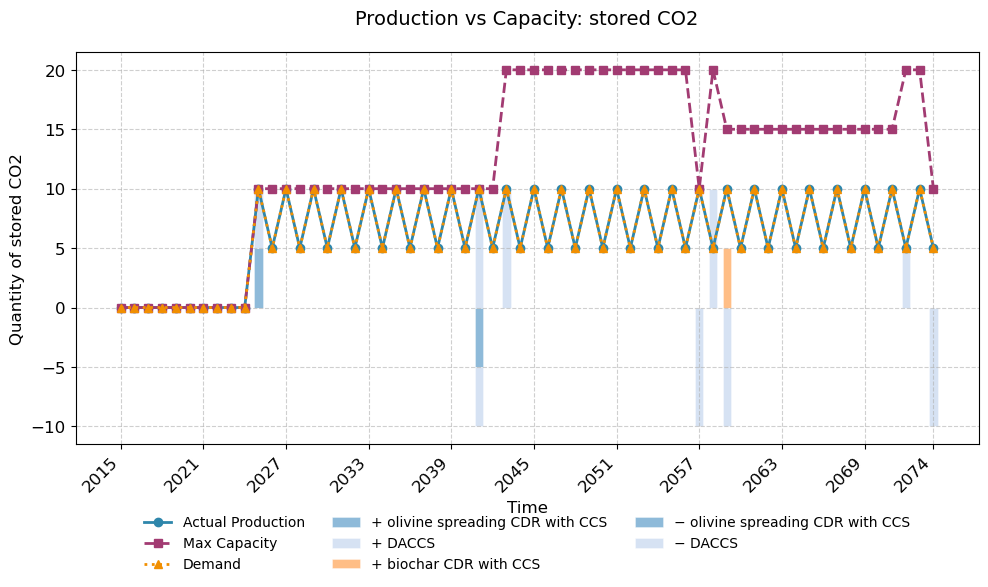

In [22]:
pp.plot_production_vs_capacity(show_capacity_changes=True)

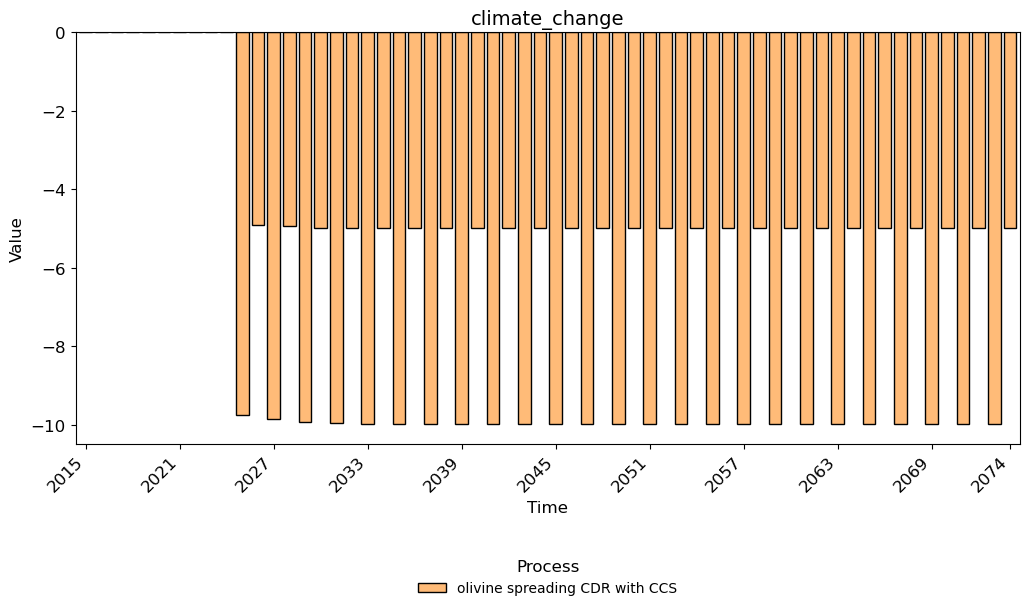

In [53]:
pp.plot_impacts()

In [54]:
pp.get_operation()

Process,4a7994a0a2a94779b1671d037affea4b,7c036e8bd49342729f3e7613cfc14e51,a124a0637daf4517825e542642d008ea,f23c810c85b44ad68d0ac0bf19565c51
Time,,,,
2015,0.0,0.0,0.0,0.0
2016,0.0,0.0,0.0,0.0
2017,0.0,0.0,0.0,0.0
2018,0.0,0.0,0.0,0.0
2019,0.0,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0


In [55]:
pp.get_installation()

Process,4a7994a0a2a94779b1671d037affea4b,7c036e8bd49342729f3e7613cfc14e51,a124a0637daf4517825e542642d008ea,f23c810c85b44ad68d0ac0bf19565c51
Time,,,,
2015,0.0,0.0,0.0,0.0
2016,0.0,0.0,0.0,0.0
2017,0.0,0.0,0.0,0.0
2018,0.0,0.0,0.0,0.0
2019,0.0,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0


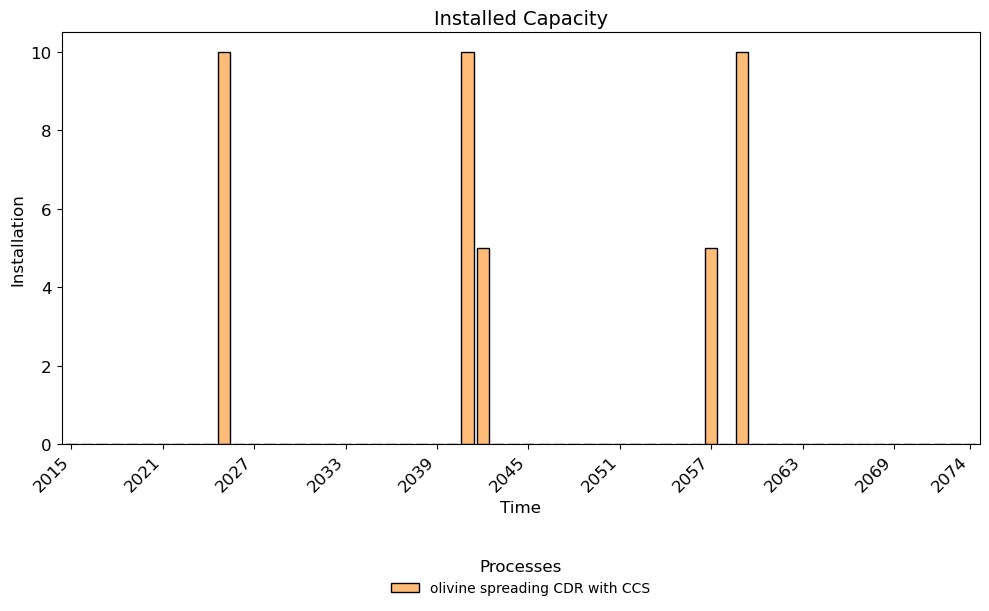

In [56]:
pp.plot_installation()

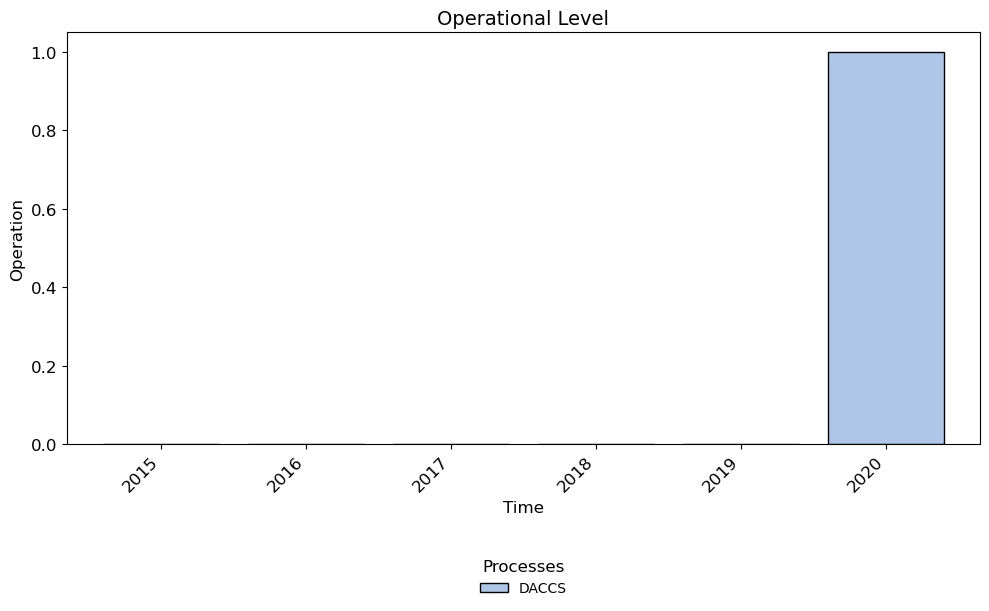

In [28]:
pp.plot_operation()

In [29]:
pp.get_impacts()

Category,climate_change
Process,f23c810c85b44ad68d0ac0bf19565c51
Time,
2015,0.000000
2016,0.000000
2017,0.000000
2018,0.000000
2019,0.000000
2020,-0.672833


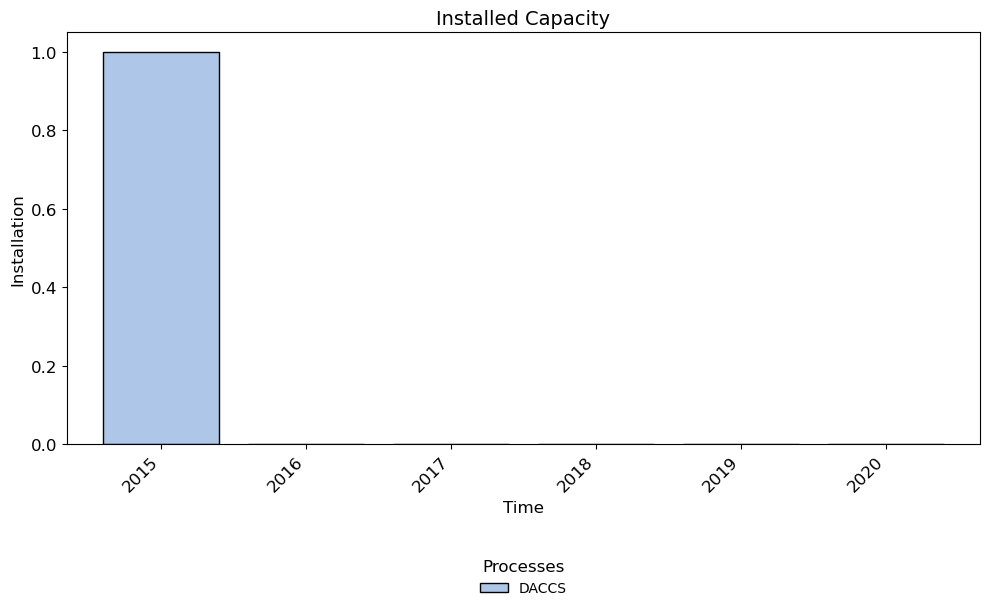

In [30]:
pp.plot_installation()

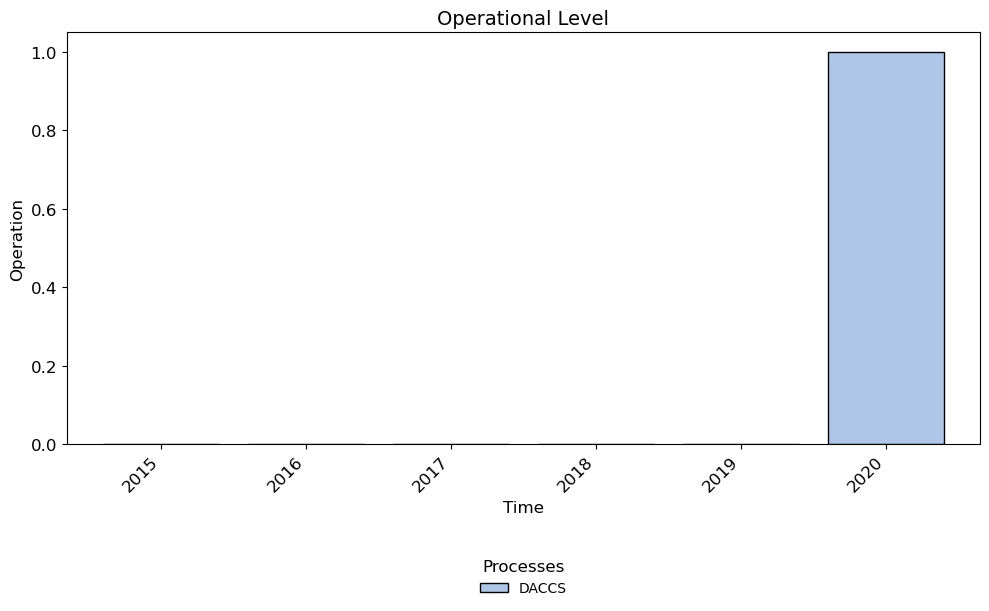

In [31]:
pp.plot_operation()

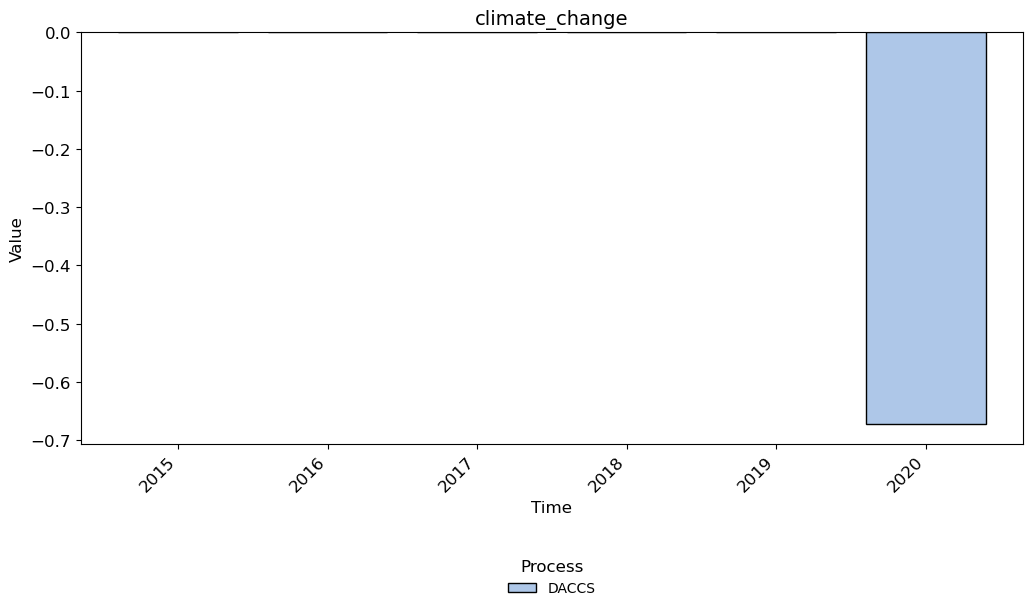

In [32]:
pp.plot_impacts()

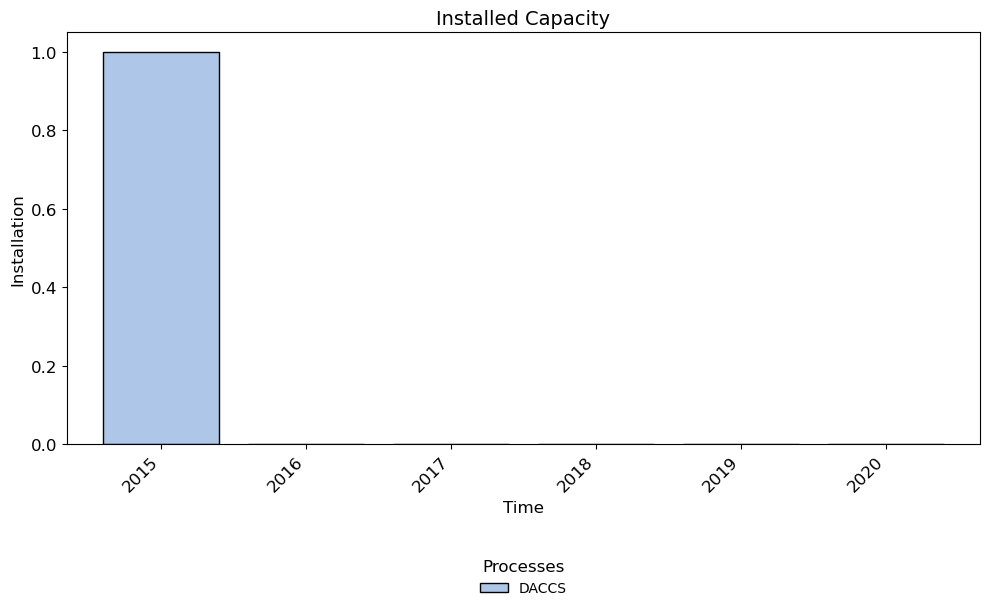

In [33]:
pp.plot_installation()

In [34]:
m.scales

{'foreground': 0.3925, 'characterization': {'climate_change': 1530.0}}

In [30]:
model.scales

{'foreground': 4.909090909090909,
 'characterization': {'climate_change': 2.3348057260696622e-11}}

In [29]:
pp.get_operation()

Process,693b3d79849340fd9f8af7a47041607c,dac305c0bdeb4e6d8fcde37f622240d0
Time,,
2015,0.0,0.0
2016,0.0,0.0
2017,0.0,0.0
2018,0.0,0.0
2019,0.0,0.0
2020,0.0,540.0
2021,0.0,540.0
2022,0.0,540.0
2023,0.0,540.0


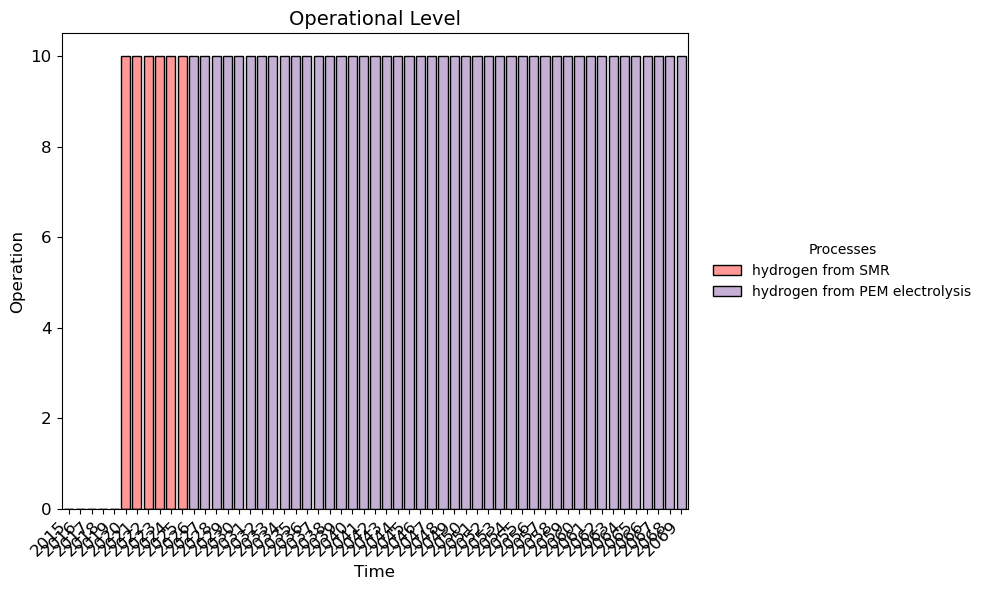

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [37]:
pp.plot_operation()

# --------------------------

### Plotting the resulting radiative forcing 

In [319]:
import pyomo.environ as pyo 
fg_scale = getattr(pp.m, "scales", {}).get("foreground", 1.0)
inventory = {
    (p, e, t): pyo.value(pp.m.scaled_inventory[p, e, t]) * fg_scale
    for p in pp.m.PROCESS
    for e in pp.m.ELEMENTARY_FLOW
    for t in pp.m.SYSTEM_TIME
}

import pandas as pd

dynamic_inventory_df = pd.DataFrame.from_records(
    [(p, e, t, v) for (p, e, t), v in inventory.items()],
    columns=["activity", "flow", "date", "amount"]
).astype({
    "activity": "str",
    "flow": "str",
    # "date": "datetime64[s]",
    "amount": "float64"
})

dynamic_inventory_df['date'] = pd.to_datetime(dynamic_inventory_df['date'].astype(int), format='%Y')

In [320]:
dynamic_inventory_df

,activity,flow,date,amount
0,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2015-01-01,0.0
1,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2016-01-01,0.0
2,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2017-01-01,0.0
3,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2018-01-01,0.0
4,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2019-01-01,0.0
...,...,...,...,...
92945,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2065-01-01,0.0
92946,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2066-01-01,0.0
92947,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2067-01-01,0.0
92948,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2068-01-01,0.0


In [321]:
dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
    lambda x: bd.Database("ecoinvent-3.11-biosphere").get(code=x).id
)

In [324]:
from dynamic_characterization import characterize

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        base_lcia_method=method,
        time_horizon=100,
        fixed_time_horizon=True,
)

2025-12-10 17:27:58.254 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


<Axes: xlabel='date_rounded'>

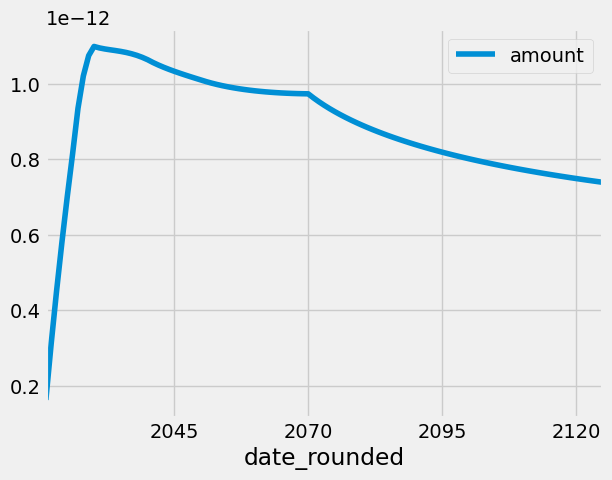

In [326]:
df_characterized['date'] = pd.to_datetime(df_characterized['date'])
df_grouped = (
    df_characterized
    .assign(date_rounded=(df_characterized['date'] + pd.offsets.MonthBegin(6)).dt.to_period('Y').dt.to_timestamp())
    .groupby('date_rounded')['amount'].sum()
    .reset_index()
)

df_grouped.plot(x='date_rounded', y='amount')